In [18]:
using BlackBoxOptim, NLsolve, Distributions, QuadGK, Plots, LaTeXStrings, LeastSquaresOptim, Roots

In [19]:
eqf(xi, w, t) = (1 - Fv(xi)) * phi(w) - t * (1 - Fv(t))
phi(x) = x - (1 - Fv(x))/fv(x)

phi (generic function with 1 method)

Calculate unconstrained auction: As in the first part. 

In [3]:
function unconstrained_auc(alpha, Fval, n)
    xi = [i for i = 0:0.1:1]
    Fv(x) = cdf(Fval, x)
    fv(x) = pdf(Fval,x)
    function pi(x)
        return  (1 - Fv(x[1])) * x[1]
    end
    #create a negative replica since the optimizer is finding the minimum. 
    pin(x) = -pi(x)
    res = bboptimize(pin ; SearchRange = (0.0 , 1.0), NumDimensions = 1);
    r_star = best_candidate(res)[1]
    
    values = []
    for xi in filter(x -> x>r_star, [i for i = 0:0.01:1])
        t = max(xi, r_star)
        eqf(xi, w, t) = (1 - Fv(xi)) * phi(w) - t * (1 - Fv(t))
        phi(x) = x - (1 - Fv(x))/fv(x)
        eqf_a(w) = eqf(xi, w, t)
        w_hat = fzero(eqf_a,0,0.999)
        #calculate lhs
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*Fv(w) + alpha * Fv(xi))^(n-1)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        l_value = quadgk(Q_eps_a, r_star, w_hat)[1]
        #calculate rhs
        t_adc = max(xi, r_star)
        Qeps2(xi,w,alpha)=(((1-alpha)*Fv(w)+alpha)^n - ((1-alpha)*Fv(w)+ alpha*Fv(xi))^n)/(alpha * (1-Fv(xi)))
        r_value = Qeps2(xi,w_hat,alpha)*max(w_hat - t_adc)
        push!(values, [r_star, xi, w_hat, l_value, r_value])
    end
    return(values)
end
#we can confirm this works ok now

unconstrained_auc (generic function with 1 method)

In [4]:
unconstrained_auc(0.8, Uniform(0,1) ,3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.09 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 106921.51
Function evals per second = 108172.37
Improvements/step = 0.64480
Total function evaluations = 10118


Best candidate found: [0.5]

Fitness: -0.250000000



51-element Vector{Any}:
 [0.49999999796982086, 0.5, 0.75, 0.06895833384087811, 0.4318749999999999]
 [0.49999999796982086, 0.51, 0.755, 0.07263394552391615, 0.42838029500000013]
 [0.49999999796982086, 0.52, 0.76, 0.07643722720721405, 0.4247193599999999]
 [0.49999999796982086, 0.53, 0.765, 0.08037034889077181, 0.42088946500000013]
 [0.49999999796982086, 0.54, 0.77, 0.08443548057458944, 0.4168878799999998]
 [0.49999999796982086, 0.55, 0.775, 0.08863479225866693, 0.4127118750000001]
 [0.49999999796982086, 0.56, 0.78, 0.09297045394300427, 0.40835871999999984]
 [0.49999999796982086, 0.57, 0.785, 0.09744463562760143, 0.40382568500000016]
 [0.49999999796982086, 0.58, 0.79, 0.10205950731245851, 0.39911004000000005]
 [0.49999999796982086, 0.59, 0.795, 0.10681723899757546, 0.39420905500000025]
 [0.49999999796982086, 0.6, 0.7999999999999999, 0.11172000068295222, 0.38911999999999985]
 [0.49999999796982086, 0.61, 0.8049999999999999, 0.11676996236858889, 0.38384014499999985]
 [0.49999999796982086, 0.

In [5]:
v_3 = [i for i = unconstrained_auc(0.8, Truncated(Chi(0.5),0,1),3)]
v_lhs3 = [i[4] for i in v_3]
v_rhs3 = [i[5] for i in v_3]

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1275651.08
Function evals per second = 1193890.02
Improvements/step = 0.22560
Total function evaluations = 9360


Best candidate found: [0.397915]

Fitness: -0.127079071



61-element Vector{Float64}:
   0.5727917927724453
   0.5693829407873319
   0.5657367429870646
   0.5618551801299095
   0.5577401599951503
   0.553393524330733
   0.5488170551129589
   0.5440124801977841
   0.5389814784324908
   0.5337256842872772
   0.5282466920585931
   0.5225460596893778
   0.5166253122457473
   ⋮
   0.15527773673349216
   0.14198658533357938
   0.12852656475358834
   0.11489896255167714
   0.10110506730223315
   0.08714616850207577
   0.0730235564640637
   0.05873852219892693
   0.04429235728618434
   0.02968635373489498
   0.01492180383500417
 NaN

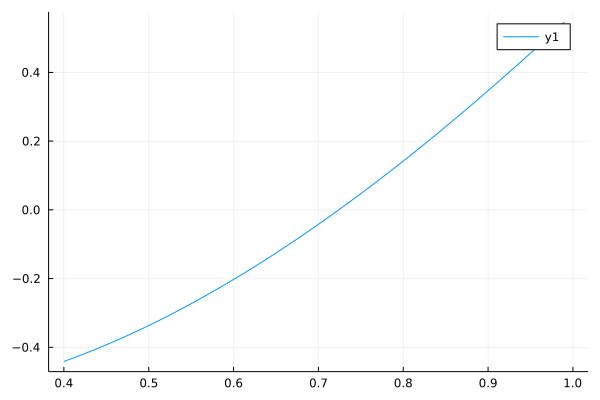

In [6]:
plot([i[2] for i in v_3], v_lhs3 .- v_rhs3)

In [7]:
#find where **continuous** functions cross the x axis by newton biscetion
function zeros(domain,value)
    if length(domain) != length(value)
        error("domain length must match value length")
    end
    zeros = []
    for i in 1:length(domain)-1
        #check for a change in signs 
        if (value[i] < 0 && value[i+1] > 0) |((value[i] > 0 && value[i+1] < 0)) #methods of bisection, might be able to improve accuracy by further nesting iterations 
            zero = push!(zeros,(domain[i] + domain[i+1])/2)
        #implement checks if values is just zero
        elseif (value[i] == 0) | (value[i+1] == 0)
            if value[i] == 0
                zero = push!(zeros, domain[i])
            else
                zero = push!(zeros, domain[i+1])
            end
        else
            continue
        end
    end
    return(zeros)
end

zeros (generic function with 1 method)

In [8]:
zeros([i[2] for i in v_3], v_lhs3 .- v_rhs3)

1-element Vector{Any}:
 0.725

In [86]:
using LeastSquaresOptim
function optimum_auc(alpha, F_val, n)

    F(x) = cdf(F_val, x)
    f(x) = pdf(F_val, x)
    
    #2. solve for rstar, xi2
    unconstrained = unconstrained_auc(alpha, F_val,n)
    unconstrained_lhs = [i[4] for i in unconstrained]
    unconstrained_rhs = [i[5] for i in unconstrained]
    r_star = unconstrained[1][1]
    xi2 = zeros([i[2] for i in unconstrained], unconstrained_lhs .- unconstrained_rhs)[1] #since lhs - rhs is single crossing, we would need 
    
    OptimAucs0 = [[i[2],[r_star,max(i[1],i[2]),i[3],i[3]]] for i in unconstrained if i[2] > xi2]
    phi(x) = x - (1 - F(x))/f(x)
    Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
    rev_int(x) = phi(x) * f(x)
    Revenue(alpha,xi,r,t,v_min,v_max) = n*(1-alpha)*Qeps2(xi,v_min,v_max,alpha)*quadgk(rev_int,r,1)[1] + n*alpha*Qeps2(xi,v_min,v_max,alpha)* quadgk(rev_int,r,1)[1]*t*(1-F(t))
    OptimRev0 = [[i[1],Revenue(alpha,i[1],i[2][1],i[2][2],i[2][3],i[2][4])] for i in OptimAucs0]
    
    #3. solve for xi1
    function max_return(f,set)
        optimum_auc = []
        maximum_rev = maximum([f(set[i]) for i = 1:maximum(size(set))])
        for i in 1:maximum(size(set))
            if f(set[i]) == maximum_rev
                push!(optimum_auc, set[i])
            end
        end
        return(optimum_auc, maximum_rev)
    end
    makes_sense(b) = (0 < b[1] <= b[2] <= b[3] <= b[4]) # && (b[1] > r_star) && (b[2] > r_star) && (b[3] > r_star) && (b[4] )
    grid_initial_raw = [[i;j;k;l] for i = 0:0.1:1 for j = 0:0.1:1 for k = 0:0.1:1 for l = 0:0.1:1]
    grid_initial = filter((x) -> makes_sense(x),grid_initial_raw)

    OptimAucs = []
    OptimRev1 = []
    #for xi,best auc pairs. Aucs are calculated like in lemma 4, and we find xi2 when xi = t*. 
    for xi in filter(x -> x < xi2, [i for i = 0:0.01:0.99])
        #optim auctions for given xi
        OptimAuc = []
        #the needed equations, we put it inside the loop as they changes with xi
        phi(x) = x - (1 - F(x))/f(x)
        eq1_new(alpha,xi,t,v_min, v_max) = alpha * (t*(1-F(t))-(1-F(xi))*phi(v_max)) - (1-alpha)*((v_min-t)*((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))* f(v_min) + (F(v_max)-F(v_min))*((v_max - (1-F(v_max))/f(v_max))-((1-F(v_min))*v_min-(1-F(v_max))*v_max)))
        phidiff(v_max,v_min) = ((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))
        Fp(s)= F(s)^(n-1)
        eq2(alpha, t, v_min, v_max) = -alpha*(-f(t)*t+(1-F(t))) - (1-alpha)*phidiff(v_max,v_min)*f(v_min)
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)
        Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
        eq3(r,v_min,v_max)= -(r - (1-F(r))/f(r))*f(r) - phidiff(v_max,v_min)*f(v_min)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        eq4_new(alpha,xi,r,t,v_min,v_max) = quadgk(Q_eps_a, r_star, v_min)[1] - Qeps2(xi,v_min,v_max,alpha) * max(v_min - t, 0)
        adheqvec(alpha,xi, r, t, v_min, v_max) = [eq1_new(alpha, xi, t, v_min, v_max)  eq2(alpha, t, v_min, v_max) eq3(r,v_min,v_max) eq4_new(alpha, xi, r, t, v_min, v_max)]
        adeqvec(x) = adheqvec(alpha,xi,x[1],x[2],x[3],x[4])
        
        for i in filter(x -> (x[1] != 1.0 && x[2] != 1.0 && x[3] != 1.0 && x[4] != 1.0), grid_initial)
            result = LeastSquaresOptim.optimize(adeqvec,i,Dogleg()).minimizer
            if makes_sense(result) == false
                continue
            else
                push!(OptimAuc, result)
            end
        end
        rev_int(x) = phi(x) * f(x)
        Revenue(alpha,xi,r,t,v_min,v_max) = n*(1-alpha)*Qeps2(xi,v_min,v_max,alpha)*quadgk(rev_int,r,1)[1] + n*alpha*Qeps2(xi,v_min,v_max,alpha)* quadgk(rev_int,r,1)[1]*t*(1-F(t))
        Revenue2(auc) = Revenue(alpha,xi,auc[1], auc[2], auc[3], auc[4])
        bestauc,bestrev = max_return(Revenue2,OptimAuc)
        push!(OptimAucs,[xi,bestauc])
        push!(OptimRev1, [xi,bestrev])
        #this works as well, just need to discard similar ones   
    end
    
    
  
    xi1 = zeros([Aucs[1] for Aucs in OptimAucs], [Aucs[2][1][2] - Aucs[1] for Aucs in OptimAucs])[1]
    OptimAucs1 = [i for i in OptimAucs if i[1] < xi1]
    
    #compute soln with t = xi inbetween xi1 and xi2
    OptimAucs2 = []
    OptimRev2 = []
    for xi in filter(x -> (x > xi1) && (x < xi2), [i for i = 0:0.01:1])
        OptimAuc = []
            phi(x) = x - (1 - F(x))/f(x)
            eq1_new(alpha,xi,t,v_min, v_max) = alpha * (t*(1-F(t))-(1-F(xi))*phi(v_max)) - (1-alpha)*((v_min-t)*((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))* f(v_min) + (F(v_max)-F(v_min))*((v_max - (1-F(v_max))/f(v_max))-((1-F(v_min))*v_min-(1-F(v_max))*v_max)))
            phidiff(v_max,v_min) = ((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))
            Fp(s)= F(s)^(n-1)
            eq2(alpha, t, v_min, v_max) = -alpha*(-f(t)*t+(1-F(t))) - (1-alpha)*phidiff(v_max,v_min)*f(v_min)
            Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)
            Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
            eq3(r,v_min,v_max)= -(r - (1-F(r))/f(r))*f(r) - phidiff(v_max,v_min)*f(v_min)
            Q_eps_a(w) = Q_eps(alpha, w, xi, n)
            eq4_new(alpha,xi,r,t,v_min,v_max) = quadgk(Q_eps_a, r_star, v_min)[1] - Qeps2(xi,v_min,v_max,alpha) * max(v_min - t, 0)
            adheqvec(alpha,xi, r, t, v_min, v_max) = [eq1_new(alpha, xi, t, v_min, v_max)  eq2(alpha, t, v_min, v_max) eq3(r,v_min,v_max) eq4_new(alpha, xi, r, t, v_min, v_max)]
            adeqvec2(x) = adheqvec(alpha,xi,x[1],xi,x[2],x[3])
        for i in filter(x -> (x[1] != 1.0 && x[2] != 1.0 && x[3] != 1.0), [[i[1],i[2],i[3]] for i in grid_initial])
            result = LeastSquaresOptim.optimize(adeqvec2,i,Dogleg()).minimizer
            if (result[1] <= xi <= result[2] <= result[3]) == false
                continue
            else
                push!(OptimAuc, result)
            end
        end
        rev_int(x) = phi(x) * f(x)
        Revenue(alpha,xi,r,t,v_min,v_max) = n*(1-alpha)*Qeps2(xi,v_min,v_max,alpha)*quadgk(rev_int,r,1)[1] + n*alpha*Qeps2(xi,v_min,v_max,alpha)* quadgk(rev_int,r,1)[1]*t*(1-F(t))
        Revenue2(auc) = Revenue(alpha,xi,auc[1], xi, auc[2], auc[3])
        bestauc,bestrev = max_return(Revenue2,OptimAuc)
        push!(OptimAucs2,[xi,[bestauc[1][1],xi,bestauc[1][2],bestauc[1][3]]])#xi, auction pairs   
        push!(OptimRev2,[xi, bestrev])
    end
    
    XiAuc = append!(OptimAucs1,OptimAucs2,OptimAucs0)
    XiRev = append!(OptimRev1, OptimRev2, OptimRev0)
    best_threshold =  [i[1] for i in XiRev if i[2] == maximum(filter!(x -> !isnan(x),[i[2] for i in XiRev]))]
    

    #report r_star, xi1, xi2, constrained sol, sols inbetween, unconstrained sol
    return(r_star,xi1,xi2,XiAuc,XiRev,best_threshold)
end
        

optimum_auc (generic function with 1 method)

In [87]:
r_star,xi1,xi2,XiAuc, XiRev, best_threshold = optimum_auc(0.8, Truncated(Normal(0.5,0.15),0,1),3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1691079.79
Function evals per second = 1706467.08
Improvements/step = 0.54120
Total function evaluations = 10092


Best candidate found: [0.386868]

Fitness: -0.299774461



(0.38686775469732815, 0.555, 0.635, Vector{Any}[[0.0, Any[[0.4, 0.5999999999999999, 0.8999999999999999, 0.9]]], [0.01, Any[[0.4, 0.5999999999999999, 0.9, 0.9]]], [0.02, Any[[0.4, 0.5999999999999999, 0.9, 0.9]]], [0.03, Any[[0.39999999999999997, 0.6, 0.8, 0.9]]], [0.04, Any[[0.4, 0.5999999999999999, 0.9, 0.9]]], [0.05, Any[[0.4, 0.5999999999999999, 0.9, 0.9]]], [0.06, Any[[0.4, 0.6, 0.9, 0.9]]], [0.07, Any[[0.4, 0.5999999999999999, 0.9, 0.9]]], [0.08, Any[[0.4, 0.6, 0.8999999999999999, 0.9]]], [0.09, Any[[0.4, 0.6000000000000001, 0.8, 0.9]]]  …  [0.91, [0.38686775469732815, 0.91, 0.9434939844889033, 0.9434939844889033]], [0.92, [0.38686775469732815, 0.92, 0.9508458007650444, 0.9508458007650444]], [0.93, [0.38686775469732815, 0.93, 0.9579597937396531, 0.9579597937396531]], [0.94, [0.38686775469732815, 0.94, 0.9648171243349216, 0.9648171243349216]], [0.95, [0.38686775469732815, 0.95, 0.9714023334989508, 0.9714023334989508]], [0.96, [0.38686775469732815, 0.96, 0.9777039967819359, 0.9777039

In [85]:
 [i[1] for i in XiRev if i[2] == maximum(filter!(x -> !isnan(x),[i[2] for i in XiRev]))]

1-element Vector{Float64}:
 0.63

In [88]:
example2 = optimum_auc(0.8, Truncated(Normal(0.4,0.5),0,1),3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1030593.93
Function evals per second = 1011839.00
Improvements/step = 0.23470
Total function evaluations = 9819


Best candidate found: [0.442023]

Fitness: -0.230798490



(0.4420232379380265, 0.605, 0.765, Vector{Any}[[0.0, Any[[0.3535647239858777, 0.4653891654685369, 0.46612095795274766, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.4661209579527476, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.4661209579527476, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.46612095795274766, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.46612095795274766, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.46612095795274766, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.46612095795274766, 0.5636402021994406], [0.35356472398587774, 0.465389165468537, 0.4661209579527477, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.4661209579527476, 0.5636402021994406], [0.3535647239858777, 0.4653891654685369, 0.46612095795274766, 0.5636402021994406]  …  [0.3535647239858777, 0.46538916546853687, 0.4661209579527476, 0.5636402021994406], [0.3535647239858777, 0.46538916

In [17]:
#try chisquare, chi distributions doesnt work
optimum_auc(0.8, Truncated(Chisq(0.5),0,1),3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 6191 steps and 0.01 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 1014729.82
Function evals per second = 938842.26
Improvements/step = 0.11040
Total function evaluations = 5728


Best candidate found: [0.365515]

Fitness: -0.064863719



(0.36551458522798963, 0.5, 0.695, Vector{Any}[[0.0, Any[[0.3224020869282582, 0.37725137001331793, 0.378168525760656, 0.4227156983050047]]], [0.01, Any[[0.30892818070175615, 0.38136262250480635, 0.3908201131400531, 0.45041617123229355], [0.30892818070175615, 0.38136262250480635, 0.3908201131400531, 0.4504161712322938], [0.30892818070175615, 0.38136262250480635, 0.39082011314005305, 0.4504161712322937]]], [0.02, Any[[0.30571423516145596, 0.38237872017006014, 0.3955641140677493, 0.4589335375760438]]], [0.03, Any[[0.3, 0.3, 0.3, 0.9000000000000001]]], [0.04, Any[[0.3, 0.3, 0.3, 0.8]]], [0.05, Any[[0.2999672590512091, 0.38423145793696095, 0.4064761316988475, 0.4768634495737954], [0.2999672590512087, 0.3842314579369609, 0.4064761316988474, 0.476863449573796], [0.29996725905120886, 0.3842314579369609, 0.40647613169884744, 0.47686344957379584], [0.2999672590512091, 0.3842314579369609, 0.4064761316988474, 0.47686344957379606], [0.29996725905120863, 0.3842314579369609, 0.40647613169884744, 0.476

In [23]:
function returnpair(x)
    return(x,x+1)
end


returnpair (generic function with 1 method)

In [24]:
a,b = returnpair(2)

(2, 3)

In [25]:
a

2

In [26]:
b

3

In [43]:
NaN

NaN

In [66]:
filter!(x -> x !== NaN,[NaN,1,2,3,4])

4-element Vector{Float64}:
 1.0
 2.0
 3.0
 4.0

In [82]:
isnan(NaN)

true